# Sentiment Analysis Performance Assessment

### John Foster
### Department of Information Technology, Western Governors University
### D213: Advanced Data Analytics
### Professor William Sewell
### June 30, 2023

### A1: RESEARCH QUESTION

The research question that I have elected to pursue in this analysis is as follows:

“With what degree of accuracy can we utilize a recurrent neural network (RNN) to perform a sentiment analysis on movie reviews sourced from IMDb?”

From a business perspective, this type of analysis would be extremely relevant to film and television production studios for the purposes of market research. By using an effectively generalized sentiment analysis pipeline to evaluate feedback on specific films and shows, studios gain the ability to plan productions that cater to emerging market trends based on audience sentiment toward specific genres and artists.

### A2: OBJECTIVES OR GOALS

The primary goal of this analysis will be to develop an RNN utilizing the IMDb review dataset that demonstrates at least 75% accuracy on a testing subset of the data on which it was not trained or validated. This threshold was selected because it represents a reasonable but significant improvement over random accuracy (50%) in a dataset with balanced binary classes.

To accomplish this, we will construct a basic model architecture using an embedding layer, a bidirectional LSTM layer, a dropout layer, and a sigmoidally-activated dense layer to produce our final output.

We will perform a grid search to determine the optimal hyperparameters within this base model architecture, and our final model selection will rely upon average accuracy on our test dataset over 10 iterations using the same hyperparameter configuration.

### A3: PRESCRIBED NETWORK

The type of neural network that we will be using to perform this sentiment analysis is a Recurrent Neural Network (RNN). Unlike a feedforward network, an RNN uses memory to maintain a running internal state in its calculations, which allows it to effectively understand context and temporal patterns in its conceptualization of sequenced data. This contextual understanding makes an RNN a highly effective tool in natural language processing, as the meaning of an individual word can so drastically change based on the presence of and relative position to other words in a statement. 

### B1: DATA EXPLORATION

Before we can build our model, we must perform exploratory analysis on our input data. We will first return a count of all special character combinations found in our sentence list using the following code:

In [144]:
#Call our random seeds for reproducibility
import random
random.seed(0)
from numpy.random import seed
seed(0)
from tensorflow.random import set_seed
set_seed(0)

#Load our libraries and packages
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, GridSearchCV
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

#download our necessary wordsets for execution of various nltk functions
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\johnf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\johnf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\johnf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [145]:
#Data format per line (observation) is as follows:
#'sentence'\t'score'\n

sentence_list = []
score_list = []

#Read our data
with open('imdb_labelled.txt', 'r', encoding='utf8') as f:
    text = f.readlines()

#Split our lines into sentence and score
for i in text:
    sentence_list.append(i.split('\t')[0])
    score_list.append(int(i.split('\t')[1].split('\n')[0]))

In [146]:
#Evaluate the sentences for unusual characters that would affect our analysis
unusual_chars = re.compile(r"[^a-zA-Z0-9\s]+")
unusual_chars_count = {}

#Make a 
for sentence in sentence_list:
    unusual_chars_found = unusual_chars.findall(sentence)
    for char in unusual_chars_found:
        if char not in unusual_chars_count:
            unusual_chars_count[char] = 1
        else:
            unusual_chars_count[char] += 1

print('Unusual characters and their counts:')
print('---')
for char, count in unusual_chars_count.items():
    print(str(char) + ' : ' + str(count))



Unusual characters and their counts:
---
, : 637
- : 142
. : 900
& : 9
... : 29
' : 332
" : 72
 : 5
? : 10
; : 11
/ : 20
: : 23
*** : 3
é : 4
( : 49
"), : 1
), : 7
! : 75
) : 34
". : 6
!! : 3
$ : 1
). : 9
.... : 3
-- : 13
!, : 1
** : 1
+! : 1
+ : 2
:) : 2
") : 1
,( : 1
% : 1
'. : 2
!). : 1
å : 1
.. : 1
 : 1
", : 1
............. : 1
........ : 1
??? : 1
..." : 1
".... : 1
," : 1
?! : 1
?-- : 1
;) : 1


Next we will evaluate the total vocabulary size of the sentence list. This is an important step that will have an impact on the final complexity of our RNN model.  As a point of note, we will actually perform this step again using functions and methods native to the Tokenizer class after we lemmatize the words in the sentence list and remove all stop words. The initial evaluation for vocabulary size will be performed by executing the following code:

In [147]:
# Combine all sentences into a single string
text = ' '.join(sentence_list)
#Tokenize our words
words = tf.keras.preprocessing.text.Tokenizer()
words.fit_on_texts(sentence_list)
#Get our unique vocabulary list
vocab = set(words.word_index.keys())
#store the length of the list
vocab_size = len(vocab)

#Return our INITIAL vocabulary size BEFORE processing
print(f"Vocabulary size: {vocab_size}")


Vocabulary size: 3133


Now we will perform an initial analysis for the embedding length of each word. This is necessary to ensure that there are enough character spaces so as not to truncate or confuse any important words when we tokenize them. Again, we will repeat this step after the sentences have been filtered for stop words and lemmatized, as they will ultimately change the results of our final word embedding length. The initial evaluation will be performed by executing the following code:

In [148]:
# Combine all sentences into a single string
text = ' '.join(sentence_list)

# Tokenize the text into words
words = tf.keras.preprocessing.text.Tokenizer()
words.fit_on_texts(sentence_list)

# Calculate the average word length
total_length = sum(len(word) for word in words.word_index.keys())
average_length = total_length / len(words.word_index.keys())

# Evaluate the proposed embedding length
embedding_length = int(average_length) + 1

#Return our INITIAL counts of average word length and proposed embedding length BEFORE processing
print(f"Average word length: {average_length}")
print(f"Proposed embedding length: {embedding_length}")

Average word length: 6.547717842323651
Proposed embedding length: 7


Next we will generate our maximum proposed maximum sequence length based on our current unprocessed data. We will perform this step again after lemmatization and filtering for stop words. We do this to determine how many spaces for individual tokenized words we should reserve for embedding in our RNN model.

We can accomplish this step by executing the following code:

In [149]:
#make a quick function to return maximum sequence length
def get_maximum_sequence_length(data):
    max_length = 0
    for sequence in data:
        words = sequence.split()
        length = len(words)
        if length > max_length:
            max_length = length
    return max_length

print(get_maximum_sequence_length(sentence_list))

71


### B2: TOKENIZATION

At this point, we must elaborate on some additional steps that are necessary to perform before we can tokenize our data. First, we will effectively drop all punctuation contained in our sentence lists to reduce the vocabulary size of the data. Worth noting is that we will handle the “-” character by replacing it with a space in order to further reduce the vocabulary size of the model. Next we will make all characters in the sentence list lowercase to further reduce the vocabulary size of the model. We can accomplish this string recognition using the ‘re’ (regular expression) library. 

In [150]:

# Remove unusual characters from sentence_list
sentence_list_cleaned = []

#Replace dashes with spaces and remove all other unusual characters
for sentence in sentence_list:
    cleaned_sentence = sentence.replace("-", " ")
    cleaned_sentence = unusual_chars.sub('', cleaned_sentence)
    sentence_list_cleaned.append(cleaned_sentence)

sentence_list = sentence_list_cleaned


#Re-evaluate for filtered characters
unusual_chars = re.compile(r"[^a-zA-Z0-9\s]+")
unusual_chars_count = {}

for sentence in sentence_list:
    unusual_chars_found = unusual_chars.findall(sentence)
    for char in unusual_chars_found:
        if char not in unusual_chars_count:
            unusual_chars_count[char] = 1
        else:
            unusual_chars_count[char] += 1

#Make an assertion check to ensure the operation was successful
assert len(unusual_chars_count.items()) == 0


At this time, we will create and execute functions to lemmatize the words in the sentences and remove all stop words. Lemmatization involves reducing the expressions of different words to their base forms (called lemma) in order to unify their various grammatical expressions. Stop words, on the other hand are extremely common words found in a language that are more related to linguistic syntax than actual meaning in a given text, including various prepositions and articles such as “a,” “in,” and “the.” These steps are accomplished by executing the following code using methods contained in the ntlk library:

In [151]:
#get our list of stop words for filtering
english_stop_words = stopwords.words('english')

processed_list = []
#Make our text lower case
for sentence in sentence_list:
    sentence = sentence.lower()
    processed_list.append(sentence)

#define our lemmatization and stop word removal functions
def get_lemmatized_text(corpus):
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

def remove_stop_words(corpus):
    removed_stop_words = []
    for sentence in corpus:
        removed_stop_words.append(
            ' '.join([word for word in sentence.split() if word not in english_stop_words])
        )
    return removed_stop_words

#Execute the functions on our processed list
processed_list = remove_stop_words(processed_list)
processed_list = get_lemmatized_text(processed_list)

#Print an example
print(processed_list[0])


slow moving aimless movie distressed drifting young man


Once we have lemmatized the text and removed stop words, we can now re-evaluate the text for vocabulary size, embedding length, and maximum sequence length using the same methods used before:

In [152]:
# Combine all sentences into a single string
text = ' '.join(processed_list)

# Instantiate our tokenizer class object and tokenize the text into words
words = tf.keras.preprocessing.text.Tokenizer()
words.fit_on_texts(processed_list)

# Remove duplicates using the set function to get our unique vocabulary
vocab = set(words.word_index.keys())

# Calculate the vocabulary size as the length of the total word set
vocab_size = len(vocab)

# Calculate the average word length
total_length = sum(len(word) for word in words.word_index.keys())
average_length = total_length / len(words.word_index.keys())

# Evaluate the proposed embedding length
embedding_length = int(average_length) + 1

#Output our observations according to rubric criteria:
print(f"Vocabulary size: {vocab_size}")
print(f"Average word length: {average_length}")
print(f"Proposed embedding length: {embedding_length}")

print("max sequence length = " + str(get_maximum_sequence_length(processed_list)))

Vocabulary size: 2820
Average word length: 6.654255319148936
Proposed embedding length: 7
max sequence length = 44


We are now ready to begin tokenization. This process essentially involves breaking down individual words into tokens that can be processed and analyzed through the RNN. This process basically standardizes the representations of these words by enforcing a structured and sequenced format. This allows each word to be distinct in its impact on the overall sentiment of the text.

For the actual tokenization process, we instantiate our tokenizer class object (contained in the tf.keras.preprocessing.text module). We then fit the tokenizer object on our processed list of sentences, effectively constructing our vocabulary of tokenized words. These steps will be executed via the following code.

In [153]:
# Tokenize the sentences
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(processed_list)

### B3: PADDING PROCESS

Next we will convert the sentences to sequences of tokens using the texts_to_sequences function (also from the tensorflow library). Because the sequences all need to be of the same length, we next use the pad_sequences function (from tensorflow) to pad shorter sequences with zeroes at the start of each sequence in order to make them all of the same length. The code necessary to execute this code can be found below, including a print function to visualize a single padded sequence from our final list:

In [154]:
#Generate our sequences of tokenized words
sequences = tokenizer.texts_to_sequences(processed_list)
# Pad sequences to a fixed length
maxlen = max(len(seq) for seq in sequences)
padded_sequences = sequence.pad_sequences(sequences, maxlen=maxlen)
#Make an array out of our scores for use later
scores = np.array(score_list)
#generate our vocabulary size
vocab_size = len(tokenizer.word_index) + 1

#Print the first padded sequence
print(padded_sequences[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0  204  314 1068    1 1069 1070
  315   71]


### B4: CATEGORIES OF SENTIMENT

There will only be two categories of sentiment that we will assign our sentences to: positive and negative. Since this makes our classification binary, our final output error will consist of a Dense layer using sigmoidal activation, returning a value between 0 (negative) and 1 (positive).

### B5: STEPS TO PREPARE THE DATA

Our final step before constructing and training our model is to determine the ratio by which we will split our data into training, validation, and testing sets. In this analysis, we will choose to use 80% (800 observations) of the data for training, 10% (100 observations) for validation, and 10% (100 observations) for testing, as this is considered to be an industry standard splitting criteria (Bahetti, 2021). 

The code to split the datasets can be found below:


In [155]:
#Create a dataframe and load our scores into it
df = pd.DataFrame()
df['score'] = scores

#Reshape our sequences for storage in dataframe
reshaped_array = padded_sequences.reshape(1000, 44, 1)
# Create a list to hold our sequences
sequence_list = []

#Make each sequence its own list value
for sequence in reshaped_array:
    sequence_list.append(sequence)

#Load the list into a new df column
df['sentence'] = sequence_list

#Standardize our variable names so we can split the data
X = df['sentence']
y = df['score']

In [156]:
# Split the total dataset into 80% Training and 20% leftover
X_train, X_diff, y_train, y_diff = train_test_split(X, y, train_size=.8, random_state=0)
#Split the remaining 20% in half, resulting in 10% of the total data in the validation set, 
# and 10% in the testing set
X_valid, X_test, y_valid, y_test = train_test_split(X_diff, y_diff, train_size=.5, random_state=0)

### B6: PREPARED DATA SET

The following code exports a copy of the full prepared dataset. We have also included the code necessary to convert the pandas series objects back to their appropriate numpy array shapes for use in the RNN model.

In [157]:
# Save dataframe to CSV
df.to_csv('sentiment_clean.csv')

In [158]:
# Convert the pandas series objects back to numpy arrays
X_train = np.array(X_train.values.tolist()).reshape(X_train.shape[0], 44, 1)
y_train = np.array(y_train.values.tolist()).reshape(y_train.shape[0], 1)
X_valid = np.array(X_valid.values.tolist()).reshape(X_valid.shape[0], 44, 1)
y_valid = np.array(y_valid.values.tolist()).reshape(y_valid.shape[0], 1)
X_test = np.array(X_test.values.tolist()).reshape(X_test.shape[0], 44, 1)
y_test = np.array(y_test.values.tolist()).reshape(y_test.shape[0], 1)

### C1: MODEL SUMMARY

Before we can provide a model summary, we will first perform a grid search in order to determine optimal hyperparameters for this model. The hyperparameters that we will be evaluating will be the number of node in the embedding layer, the number of nodes in the lstm layer, and the ratio of the dropout layer. We opted to create our own grid search rather than using sklearn’s implementation as the KerasClassifier wrapper necessitated by that method introduced several limitations in how we could customize the hyperparameter search. We will search for the optimal combination of hyperparameters using the following code:

In [159]:
#Define our grid search according to the hyperparameters we are seeking to optimize
def grid_search_custom(param_grid):
    #Import global variables
    global X_train
    global y_train
    global X_valid
    global y_valid
    global vocab_size

    #Declare our running best validation accuracy and best configuration of hyperparameters
    best_valid_accuracy = 0
    best_hyperparameters = {'embedding_nodes': 0,
                            'lstm_nodes': 0,
                            'dropout_rate': 0
                            }

    #define our early stopping callback to prevent overfitting
    early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    #Create our nested for loops and train each hyperparameter combination 5 times each
    for i in range(len(param_grid['embedding_nodes'])):
        for j in range(len(param_grid['lstm_nodes'])):
            for k in range(len(param_grid['dropout_rate'])):
                #Create a running total of summed accuracy scores
                sum_accuracy = 0
                for l in range(5):
                    # Build the model for testing using values pulled from param_grid dict lists by index
                    model = Sequential()
                    model.add(Embedding(vocab_size, param_grid['embedding_nodes'][i]))
                    model.add(Bidirectional(LSTM(param_grid['lstm_nodes'][j])))
                    #Code adapted from https://keras.io/api/layers/recurrent_layers/bidirectional/
                    model.add(Dropout(param_grid['dropout_rate'][k]))
                    model.add(Dense(1, activation="sigmoid"))

                    # Compile the model
                    model.compile(loss="binary_crossentropy",
                                optimizer="adam",
                                metrics=["accuracy"])

                    # Train the model
                    model.fit(X_train, y_train,
                            batch_size=32,
                            epochs=10,  # Increase the number of epochs
                            callbacks=[early_stop],
                            validation_data=(X_valid, y_valid))

                    # Evaluate the model on the validation set
                    valid_loss, valid_accuracy = model.evaluate(X_valid, y_valid)
                    #Add the accuracy score to the summed total declared outside the loop
                    sum_accuracy += valid_accuracy
                #Divide the summed accuracy scores by the total number of tests (5) to get average validation accuracy
                avg_accuracy = sum_accuracy/5
                #Update the saved configuration for the optimal model and the best accuracy score if the model outperforms it
                if avg_accuracy > best_valid_accuracy:
                    best_valid_accuracy = avg_accuracy
                    best_hyperparameters['embedding_nodes'] = param_grid['embedding_nodes'][i]
                    best_hyperparameters['lstm_nodes'] = param_grid['lstm_nodes'][j]
                    best_hyperparameters['dropout_rate'] = param_grid['dropout_rate'][k]
    #Return the dict of the optimal configuration
    return best_hyperparameters




In [160]:
#Define our grid of parameters to evaluate in our grid search
param_grid = {
    'embedding_nodes': [32, 64, 128, 256],
    'lstm_nodes': [32, 64, 128, 256],
    'dropout_rate': [0.1, 0.3, 0.5, 0.7]
}

#Simple boolean value to turn the grid search on or off in script
#Default behavior is False so that the script can be evaluated externally
#This prevents the script taking multiple hours to run to completion
grid_search = False

if grid_search == True:
    hyperparams = grid_search_custom(param_grid)
    print(hyperparams)

As a point of note, the above code has been disabled by default because the search took several hours to complete successfully. Our best model had 256 embedding layer nodes, 32 LSTM nodes, and a .5 dropout rate.

The following code can now be executed to output our final model summary:


### C2: NETWORK ARCHITECTURE

Our final model has 4 total layers: an embedding layer that stores and represents our input data of tokenized and padded sentence sequences, a bidirectional LSTM layer to process the sequences in both directions to capture contextual patterns within the sequences, a dropout layer to zero out a proportion of the output of the LSTM layer and improve generalization by mitigating overfitting, and a final dense layer using sigmoidal activation and a single output node to accomplish the final binary classification of our sentiment analysis.

As we can see from our model summary, the total number of parameters in the model is 796,225. This number represents the total sum of weights and biases across all layers of the RNN model. The iterative tuning of these parameters based on the model’s predictions during training epochs are ultimately what improve the final predictive accuracy of the model.

In [161]:
#Explicitly define our optimal configuration to avoid running the gridsearch unnecessarily during development and evaluation

hyperparams = {'embedding_nodes': 256, 
                'lstm_nodes': 32, 
                'dropout_rate': 0.5}

                
# Build our final model for training
model = Sequential()
model.add(Embedding(vocab_size, hyperparams['embedding_nodes']))
model.add(Bidirectional(LSTM(hyperparams['lstm_nodes'])))
#Code adapted from https://keras.io/api/layers/recurrent_layers/bidirectional/
model.add(Dropout(hyperparams['dropout_rate']))
model.add(Dense(1, activation="sigmoid"))

# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

print(model.summary())


Model: "sequential_326"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_326 (Embedding)   (None, None, 256)         722176    
                                                                 
 bidirectional_326 (Bidirect  (None, 64)               73984     
 ional)                                                          
                                                                 
 dropout_326 (Dropout)       (None, 64)                0         
                                                                 
 dense_326 (Dense)           (None, 1)                 65        
                                                                 
Total params: 796,225
Trainable params: 796,225
Non-trainable params: 0
_________________________________________________________________
None


### C3: HYPERPARAMETERS

Our final model has 4 total layers: an embedding layer with 256 nodes, a bidirectional LSTM layer with 32 nodes, a dropout layer with a rate of .5, and a dense layer utilizing sigmoidal activation with a single output node.

We have chosen sigmoidal activation with a single node in our final Dense output layer because this accomplishes our final output goal of returning a value between 0 and 1, thereby allowing us to treat values above or below .5 as predictions of 1 and 0 respectively, which enables us to compare predictions against the sentiment scores of our dataset.

The remaining node counts were determined through a grid search function that we described above. Ideally, we would expand this search to include other hyperparameters and a wider number of combinations, but as the complexity and computation time increases exponentially for these types of searches as new dimensions are added, we elected to limit our grid search to embedding layer nodes, LSTM nodes, and dropout rate.

The loss function we have chosen is binary crossentropy, as it is specifically designed for classification tasks with binary output such as our own sentiment analysis. It accomplishes this by calculating logarithmic loss between predictions and expected output, punishing the model more for larger differences between its decimal output and the expected integer value of 0 or 1.

Our optimizer in this analysis was ADAM (Adaptive Moment Estimation). We chose this optimizer because it is recommended as a default optimizer in so many deep learning research analyses, making it a reliable industry standard. This is due to its ease of implementation, fast running time, minimal memory demands, and lack of tuning necessary to effectively deploy (Gupta, 2021).

Determining an appropriate stopping criterion for the model was slightly more complicated. In our grid search, we noticed that regardless of hyperparameter tuning, the model’s predictive accuracy on the training set would reach 99% somewhere between epoch 5 and 10, and validation accuracy would fail to improve any further at around this point. To compensate for the swiftness of this overfitting, we elected to create a callback function whereby the model would stop training and retain the model’s weights and biases from its best epoch if after 3 epochs, the model’s validation accuracy was not improving further. We also included another callback to save the best iteration of the model to an .h5 file for preservation and ease of comparison in our grid search.

Our chosen training metric for this model was accuracy. This was chosen because it acts as a direct measure of the proportion of correct predictions from the model against the expected outcomes. This binds the evaluation and correction of the model’s performance to how it functionally performs at the classification task.

### D1: STOPPING CRITERIA

As we described above, we opted to use a dynamic stopping criteria in order to mitigate the impact of overfitting. We defined the maximum number of training epochs as 10, included a callback function to end training if the validation accuracy stalled for 3 epochs, and saved the weights and balances of the model at the epoch where it performed best on the validation data.

An output of the model’s training can be seen by executing the code below:

In [162]:

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train the model
print("Training...")
history = model.fit(X_train, y_train,
          batch_size=32,
          epochs=10,  # Increase the number of epochs
          callbacks=[early_stop, checkpoint],
          validation_data=(X_valid, y_valid))

# Load the model
best_model = tf.keras.models.load_model('best_model.h5')
# Evaluate the best model on the test set
valid_loss, valid_accuracy = best_model.evaluate(X_valid, y_valid)
print(f'Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}')

# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Training...
Epoch 1/10


25/25 [==============================] - 6s 101ms/step - loss: 0.6877 - accuracy: 0.5350 - val_loss: 0.6965 - val_accuracy: 0.4700
Epoch 2/10
25/25 [==============================] - 2s 66ms/step - loss: 0.6451 - accuracy: 0.6913 - val_loss: 0.6741 - val_accuracy: 0.5800
Epoch 3/10
25/25 [==============================] - 2s 65ms/step - loss: 0.4798 - accuracy: 0.8637 - val_loss: 0.6022 - val_accuracy: 0.6800
Epoch 4/10
25/25 [==============================] - 2s 66ms/step - loss: 0.2415 - accuracy: 0.9500 - val_loss: 0.5023 - val_accuracy: 0.7800
Epoch 5/10
25/25 [==============================] - 2s 63ms/step - loss: 0.1148 - accuracy: 0.9737 - val_loss: 0.6350 - val_accuracy: 0.7100
Epoch 6/10
25/25 [==============================] - 2s 61ms/step - loss: 0.0868 - accuracy: 0.9812 - val_loss: 0.6657 - val_accuracy: 0.7300
Epoch 7/10
4/4 [==============================] - 1s 14ms/step - loss: 0.5023 - accuracy: 0.7800
Validation Loss: 0.5022832751274109, Validation Accuracy: 0.7799999

In [163]:
# Make predictions on the test set and round them to 0 or 1
y_pred = best_model.predict(X_test)
y_pred_bin = np.round(y_pred).flatten()

# Compute evaluation metrics
accuracy = best_model.evaluate(X_test, y_test)[1]
precision = precision_score(y_test, y_pred_bin)
recall = recall_score(y_test, y_pred_bin)
f1 = f1_score(y_test, y_pred_bin)

# Compute confusion matrix
matrix_final = confusion_matrix(y_test, y_pred_bin)

4/4 [==============================] - 0s 10ms/step - loss: 0.4869 - accuracy: 0.8100


### D2: FITNESS

The final fitness of our model can be described based on its predictive accuracy on the training versus validation data sets. As we can observe in the output from our training process in section D1, the validation accuracy of the model stalled at .78 at epoch 4 of training. The training accuracy at this epoch was .9500. Because the model failed to improve its validation accuracy at subsequent epochs, the model’s weights and biases at epoch 4 were stored as the optimal iteration of the final model. 

This early stopping process was the primary precaution that we chose to take in order to prevent overfitting on the training data. As we can see in the training output, the training accuracy continues to improve with subsequent epochs, and if the maximum number of epochs is extended in the model parameters, will approach perfect predictive accuracy on the training dataset. However, since our priority is to prevent overfitting, choosing the model with the best validation accuracy ultimately ensures that the predictive capability of our model is as generalized as possible. As we saw when the model was evaluated on the testing data, the test accuracy came out to 81%, which is roughly comparable to our validation accuracy.

From these results, we can conclude that our model is not terribly overfit, and our validation and testing accuracy scores can be generally regarded as indicative of the predictive performance of this RNN on similar datasets.

### D3: TRAINING PROCESS

The code below generates visualizations of our model’s training process, including the Training and Validation Accuracy scores of the model at every recorded epoch. As we can see, the validation loss and accuracy stall at epoch 4, while the training accuracy and loss continues to improve in the 3 subsequent epochs before the early stopping callback is executed and the weights and biases of the model after epoch 4 is saved.

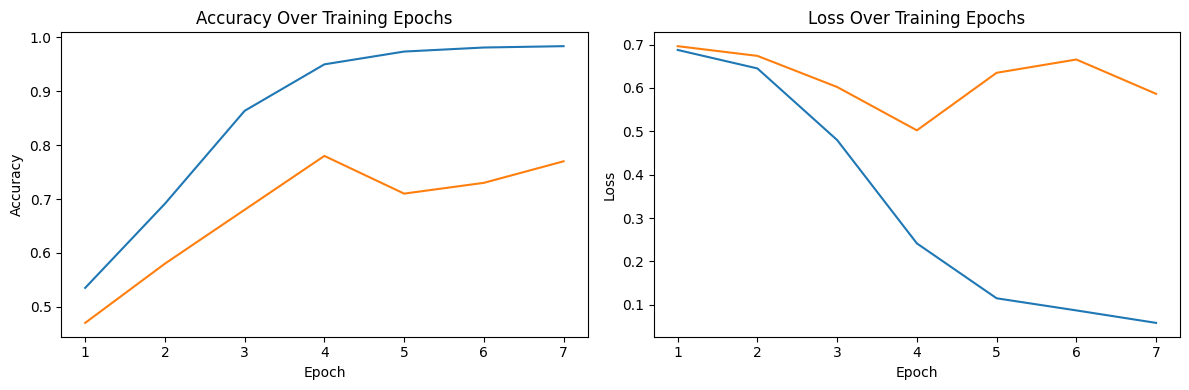

In [164]:
# Plot Training and Validation Accuracy over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Over Training Epochs")
plt.xlabel("Epoch")
plt.xticks(ticks=np.arange(len(history.history["accuracy"])), 
           labels=np.arange(1, len(history.history["accuracy"]) + 1))
plt.ylabel("Accuracy")

# Plot Training and Validation Loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Over Training Epochs")
plt.xlabel("Epoch")
plt.xticks(ticks=np.arange(len(history.history["loss"])), 
           labels=np.arange(1, len(history.history["loss"]) + 1))
plt.ylabel("Loss")

plt.tight_layout()
plt.show()


### D4: PREDICTIVE ACCURACY

As we can see from the above visualizations, the predictive accuracy of the model according to our chosen metric, validation accuracy, is 78%. In addition, we can generate several other statistics and visualizations when we run our model on our test dataset.

Our accuracy, Precision, Recall, and F1 statistics when the model is applied to the test dataset can be found below:

In [165]:
# Print evaluation metrics
print('Testing Metrics')
print('---')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Testing Metrics
---
Accuracy: 0.8100000023841858
Precision: 0.8225806451612904
Recall: 0.864406779661017
F1-Score: 0.8429752066115702


In addition, we can generate a confusion matrix to visualize the actual predictive results on the test set, and an ROC curve, complete with AUC score, to visualize the effective performance of the model at various classification cutoffs by executing the following code:

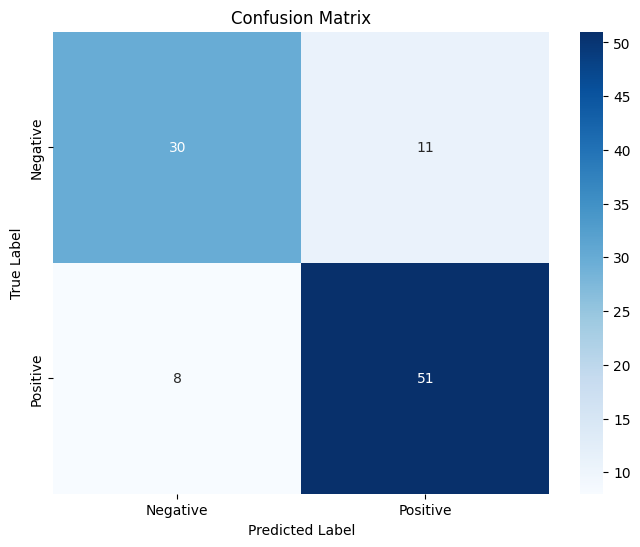

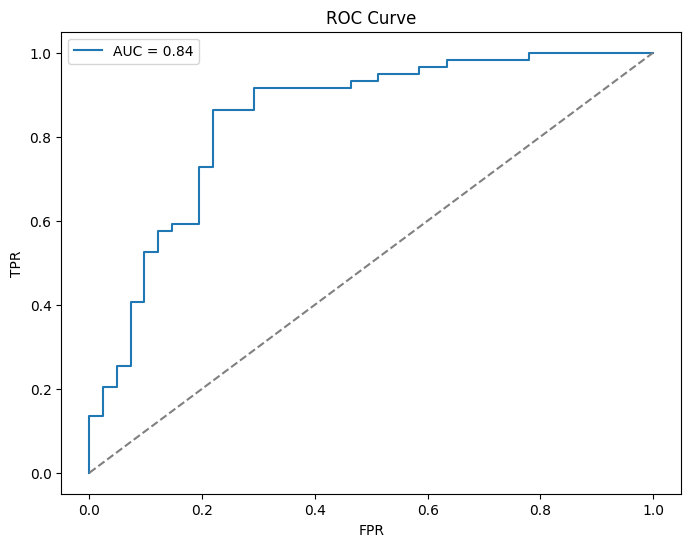

In [166]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
#sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
sns.heatmap(matrix_final, 
            annot=True, 
            fmt="d", 
            cmap="Blues", 
            yticklabels=['Negative', 'Positive'], 
            xticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve on binary predictions
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= str('AUC = ' + str(round(roc_auc, 2))))
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

As we can see, the predictive accuracy on the test data was 81%, and our final AUC score was 0.84. From these results, we can conclude that our analysis was successful according to our initial goal of a test accuracy of .75.

### E: CODE

The following code will save the final tested model to an .h5 file. As a point of note, this step was executed earlier in script, but has been included for rubric continuity.

In [167]:
#Save the final model to an .h5 file for submission
best_model.save("final_model.h5")

### F: FUNCTIONALITY

Based on the results of this analysis, we can determine that this network architecture is quite effective at performing sentiment analysis on unfamiliar data. The architecture itself was kept quite simple for two important reasons. First, a relatively small number of model layers equates to a smaller number of hyperparameters to tune. Because the time that a grid search takes increases exponentially with the number of additional dimensions introduced, this enabled us to quickly tune the model. Second, the lack of model complexity means that this model is more efficient at generating predictions for larger quantities of data, which makes it fairly scalable in its potential usefulness to a production studio performing market research.

### G: RECOMMENDATIONS

Based on the fact that both the validation accuracy and test accuracy of the model exceeded our goal of .75, we can recommend that a production studio employ our model to evaluate larger samples of reviews. By evaluating the overall sentiment toward different groups of films that share stylistic and creative similarities, a studio could tailor their strategic planning efforts to cater more effectively to different market segments based on the apparent trends of audience preferences. This would ultimately maximize box office draw and mitigate risks in production decisions.

### H: REPORTING

This WGU submission will include the Jupyter notebook file that contains this report, code, and output, as well as a .html export of that notebook file. As a point of note, due to the randomized nature of deep learning model training, the final validation and testing accuracy statistics may differ from the included output and written report if the code is executed despite our efforts to stabilize them by manipulating random number seeding at the start of the script.

### I: SOURCES FOR THIRD PARTY CODE

Chollet, F. et al. (2015)."Bidirectional Layer." Keras. https://keras.io/api/layers/recurrent_layers/bidirectional/

### J: SOURCES

Bahetti, P. (2021). "Train Test Validation Split: How To & Best Practices [2023]." https://www.v7labs.com/blog/train-validation-test-set#h1

Gupta, A. (2021). "A Comprehensive Guide on Optimizers in Deep Learning." https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/#Adam_Deep_Learning_Optimizer